In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import random
import itertools
import math
import cma
import scipy
from scipy import stats

## Import dataset

In [2]:
Data = []
with open("data.csv") as f:
    tmp = [line.split() for line in f]        # create a list of lists
    for i, x in enumerate(tmp):              #print the list items 
        Data.append(x[0].split(','))
# Data[3]
len(Data)

200006

## Assign value

In [3]:
m = int(Data[0][0])
A = int(Data[1][0])
k = int(Data[2][0])
thetab = np.array(Data[3]).astype(np.float).reshape(2,2)
n = int(Data[4][0])
Episodes = []
for i in range(n):
    Episodes.append(np.array(Data[i+5]).astype(np.float))
Episodes = np.array(Episodes)
FirstEp = np.array(Data[200005]).astype(np.float)
print("Number of state features: %d\nNumber of discrete actions: %d\nFourier basis order: %d\nParameters of the policy:%s\nNumber of episodes:%d"%(m,A,k,np.array2string(thetab),n))
print("10 example episodes:\n", Episodes[:10])
print("First Episode: ",FirstEp)

Number of state features: 1
Number of discrete actions: 2
Fourier basis order: 1
Parameters of the policy:[[ 0.01 -0.01]
 [ 1.    1.  ]]
Number of episodes:200000
10 example episodes:
 [array([ 0.419908 ,  1.       ,  0.992628 ,  0.366283 ,  0.       ,
       10.       ,  0.0622811,  1.       ,  2.98566  ,  0.327772 ,
        1.       ,  1.69524  ,  0.612293 ,  0.       ,  6.10134  ])
 array([ 0.452796,  1.      , -2.49912 ,  0.526937,  1.      ,  7.42631 ,
        0.335302,  1.      ,  7.42853 ])
 array([ 0.536244,  1.      , -3.91362 ,  0.522716,  1.      ,  1.51771 ,
        0.40803 ,  1.      , -1.25238 ])
 array([ 0.594378,  1.      ,  0.023878,  0.610604,  1.      , -1.20107 ,
        0.530918,  0.      ,  4.92925 ,  0.588444,  1.      , -3.52819 ,
        0.479734,  1.      , -2.66537 ])
 array([ 0.574179,  1.      , -0.366696,  0.407571,  1.      , -0.199698,
        0.459103,  1.      , -3.85923 ,  0.54211 ,  0.      , -2.21454 ,
        0.471514,  1.      , -0.276811])
 array

## Process

1. split Dataset $D$ into $D_c$ and $D_s$
2. Use $D_c$ to select $\theta c$ according to 
$$\theta_c\in \mathop {argmax}_{\theta} PDIS(D_c,\theta,\pi_b)$$
3. Next, run the safety test. That is, if 
$$PDIS(D_s,\theta,\pi_b)-\frac{\hat{\sigma}_s}{\sqrt{|D_s|}}t_{1-\delta,|D_s|-1}\geq c$$
holds, return $\theta c$, and otherwise return NSF.

In [4]:
# split dataset
D_c = Episodes[:120000]
D_s = Episodes[120000:]
D_c.shape, D_s.shape
# print(D_c[0])
# print(D_s[0])

((120000,), (80000,))

In [5]:
# calculate pi_b
pi_b = np.zeros((m,A))

c = [list(i) for i in itertools.product(range(k), repeat=4)] # k is dorder

In [6]:
# define FourierBasis

class FourierBasis:
    def __init__(self, inputDimension, iOrder, dOrder):
        self.inputDimension = inputDimension
        iTerms = iOrder*inputDimension;#Number of independent terms
        dTerms = int(math.pow(dOrder + 1, inputDimension))# Number of dependent terms
        oTerms = min(iOrder, dOrder)*inputDimension # Overlap of iTerms and dTerms
        self.nTerms = iTerms + dTerms - oTerms
#         print(iTerms,dTerms,oTerms,self.nTerms)
        counter = np.zeros(inputDimension)
        self.c = np.zeros((self.nTerms, inputDimension))
        termCount = 0;
        while termCount<dTerms:
            self.c[termCount] = counter
            self.incrementCounter(counter, dOrder)
            termCount+=1

        for i in range(inputDimension):# Add the independent terms
            j = dOrder+1

            while  j <= iOrder:
#                 print("================")
                self.c[termCount][i] = double(j)
                termCount+=1
                j+=1
#                 print(j)
#         print(self.c,self.c.shape)

    def getNumOutputs(self):
        return self.nTerms
    
    def incrementCounter(self,buff, maxDigit):
        for i in range(buff.shape[0]):
            buff[i]+=1
            if buff[i] <= maxDigit:
                break
            buff[i] = 0

    def basify(self, x):
        result = np.zeros(self.nTerms)
#         print("c[i] x")
        for i in range(self.nTerms):
            result[i] = np.cos(math.pi* np.dot(self.c[i], x))
#             print(c[i],x)
#             print(np.dot(self.c[i], x))
        return result

# fb = FourierBasis(4, 2, 3)
# s = np.array([0.32,0.23,1.3,-5.0])
# phi = fb.basify(s)
# print(phi)
fb = FourierBasis(m, 1, k)
s = np.array([0.419908])
phi = fb.basify(s)
print(phi)

[1.         0.24896982]


In [7]:
# define function to calculate pi_b
fb = FourierBasis(m, k, k)
def calculate_pi(s,a,fb,theta):
    phi = fb.basify(s) #2*1
    up = np.exp(phi.dot(theta[a]))
    down = np.sum(np.exp(phi.dot(theta.T)))
    return up/down
for i in range(len(Episodes[0])):
    if i%3==0:
        print(calculate_pi(np.array([Episodes[0][i]]),int(Episodes[0][i+1]),fb,thetab))

0.7758179628829157
0.19751227246411232
0.8787587888894525
0.8190914628552088
0.34501192170711364


(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=242382, Wed Dec 11 17:05:44 2019)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 2.503739675634056e+01 1.0e+00 4.31e-01  4e-01  4e-01 0:00.0
    2     16 1.441929574711749e+01 1.3e+00 3.97e-01  3e-01  4e-01 0:00.0
    3     24 1.401923563121233e+01 1.5e+00 4.48e-01  4e-01  5e-01 0:00.0
  100    800 2.366528571564528e-03 5.5e+01 1.17e-01  1e-02  7e-02 0:00.2
  187   1496 2.032982053172549e-15 5.0e+01 4.42e-06  8e-09  6e-08 0:00.4
termination on tolfun=1e-11
final/bestever f-value = 2.032982e-15 2.032982e-15
incumbent solution: [0.999999989874225, 0.9999999843977871, 0.9999999706925126, 0.9999999413703782]
std deviation: [8.41379341006891e-09, 1.5093837128346645e-08, 2.987154725795497e-08, 5.913865447311764e-08]


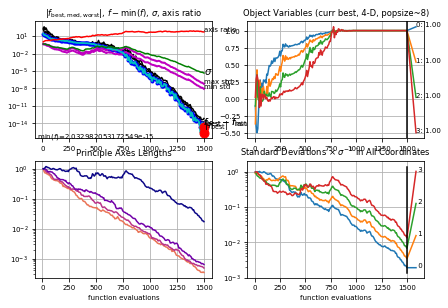

In [8]:
# create random policies
# this part can skip, it's testing cma es.
es = cma.CMAEvolutionStrategy(4 * [0], 0.5)
solutions = es.ask()
solutions
while not es.stop():
    solutions = es.ask()# ask for n policies
    es.tell(solutions,[cma.ff.rosen(x) for x in solutions])
    es.logger.add()  # write data to disc to be plotted
    es.disp()
es.result_pretty()
cma.plot()  # shortcut for es.logger.plot()


In [9]:
def calculate_PDIS_H(thetae,thetab,epi,fb):
    pie_pib = 1.0
    ret = 0.0
    for t in range(epi.shape[0]):
        if t%3==0:
            s = np.array([epi[t]])
            a = int(epi[t+1])
            r = epi[t+2]
            up = calculate_pi(s,a,fb,thetae)
            down = calculate_pi(s,a,fb,thetab)
            pie_pib = pie_pib*(up/down)
            ret+=pie_pib*r
    return ret
print(calculate_PDIS_H(np.array(es.ask(1)).reshape(2,2),thetab,Episodes[10],fb))

-0.24408174748491862


In [10]:
def calculate_PDIS_D(episodes,thetae,thetab,fb):
    ret = []
    for epi in episodes:
        ret.append(calculate_PDIS_H(thetae,thetab,epi,fb))
    return np.mean(np.array(ret)),np.std(np.array(ret), ddof=1)
print(calculate_PDIS_D(D_c,np.array(es.ask(1)).reshape(2,2),thetab,fb))

(4.061740157604892, 19.699165102595966)


In [11]:
# Using cma es to generate policy parameters(candidate selection)
from scipy.stats import t
sigma = 0.1#2.0*(thetab.reshape(-1).dot(thetab.reshape(-1)) + 1.0)# sigma not sure
print("sigma: ",sigma)
es = cma.CMAEvolutionStrategy(thetab.reshape(-1), sigma)# start search from pi_b
delta = 0.1
c = 0
min1 = 10000
D_s_size = 80000
flag = True
while not es.stop() and flag:
    solutions = es.ask(8)# ask for n policies
    tell = []
    for x in solutions:
        pred,sig = calculate_PDIS_D(D_c,np.array(x).reshape(2,2),thetab,fb)
        if pred<min1:
            min1 = pred
        t_test = pred-2*sig/np.sqrt(D_s_size)*t.ppf(1-delta,D_s_size-1)
#         print(c)
        if np.isnan(t_test):
            flag = False
        if t_test <c:
#             print("bad!")
            pred = -100000-pred
        pred = -pred
        tell.append(pred)
    es.tell(solutions,tell)
#     es.tell(solutions,[-calculate_PDIS_D(D_c[:100],np.array(x).reshape(2,2),thetab,fb)[0] for x in solutions])
    es.logger.add()  # write data to disc to be plotted
    es.disp()
es.result_pretty()
cma.plot()  # shortcut for es.logger.plot()
print("min:",min1)

sigma:  0.1
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=157958, Wed Dec 11 17:06:42 2019)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 -1.314564478848691e+00 1.0e+00 9.56e-02  8e-02  1e-01 5:21.0


KeyboardInterrupt: 

In [47]:
print(es.ask(1))

[array([ 19.59168594,   2.54659442, -38.32986174,  -2.80657086])]


In [23]:
# t test
X, delta = calculate_PDIS_D(D_c,np.array(es.ask(1)).reshape(2,2),thetab,fb)

In [24]:
safety = X-2*delta/np.sqrt(D_s_size)*scipy.stats.t.ppf(1-0.5,D_s_size-1)
print(safety)

12.337899658848881


In [285]:
print(scipy.stats.t.ppf(1-delta,D_s_size-1))

6.638010660180646e-17


In [51]:
# run safety test
solutions = es.ask(1000)
final_solutions = []
for s in solutions:
#     print(".", end="")
#     pred,_ = calculate_PDIS_D(D_c[:1000],np.array(s).reshape(2,2),thetab,fb)
    pred,sig = calculate_PDIS_D(D_s,np.array(s).reshape(2,2),thetab,fb)
    print(pred)
#     print(sig/np.sqrt(D_s_size)*scipy.stats.t.ppf(1-delta,D_s_size-1))
    safety = pred - sig/np.sqrt(D_s_size)*scipy.stats.t.ppf(1-delta,D_s_size-1)
    if safety>=c:
        print(".",end="")
        final_solutions.append(s)
    if(len(final_solutions)==100):
        break
print(len(final_solutions))
print(final_solutions)

13.911904031875608
.13.911904031875608
.13.911904031875608
.13.911904031875608
.13.911904031875608
.13.911904031875608
.13.911904031875608
.13.911904031875608
.13.911904031875608
.13.911904031875608
.13.911904031875608
.13.911904031875608
.13.911904031875608
.13.911904031875608
.13.911904031875608
.13.911904031875608
.13.911904031875608
.13.911904031875608
.13.911904031875608
.13.911904031875608
.13.911904031875608
.13.911904031875608
.13.911904031875608
.13.911904031875608
.13.911904031875608
.13.911904031875608
.13.911904031875608
.13.911904031875608
.13.911904031875608
.13.911904031875608
.13.911904031875608
.13.911904031875608
.13.911904031875608
.13.911904031875608
.13.911904031875608
.13.911904031875608
.13.911904031875608
.13.911904031875608
.13.911904031875608
.13.911904031875608
.13.911904031875608
.13.911904031875608
.13.911904031875608
.13.911904031875608
.13.911904031875608
.13.911904031875608
.13.911904031875608
.13.911904031875608
.13.911904031875608
.13.911904031875608
.

In [ ]:
import csv
for i in range(100):
    with open('./data/'+str(i+1) + '.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow([str(final_solutions[i][j]) for j in range(len(final_solutions[i]))])

## Use cartpole to test the algorithm

In [12]:
# evaluate cartpole
from rl687.environments.cartpole import Cartpole
from rl687.policies.tabular_softmax import TabularSoftmax

# def generatephi(state):
#     ret = []
#     for i in range(3):
#         for j in range(3):
#             for m in range(3):
#                 for n in range(3):
#                     ret.append((state[0]**i)*(state[1]**j)*(state[2]**m)*(state[3]**n))
#     print(len(ret))
#     return np.array(ret)


def evaluationFunction2(theta_p,numEpisodes):
    """
    evaluationFunction (function): evaluates the provided parameterized policy.
    input: theta_p (numpy.ndarray, a parameterized policy), numEpisodes
    output: the estimated return of the policy
    """

    # init the gridworld
    cartpole = Cartpole()
    returns = np.zeros(numEpisodes)

    theta = theta_p.reshape(2,-1) # divide to each function

    for epoch in range(numEpisodes):
        cartpole.reset()
        step = 0
        g = 0
        s = [0.,0.,0.,0.]
        while not cartpole.isEnd:
#             phi = generatephi(s)
            fb2 = FourierBasis(len(s), 1, 1)
            phi = fb2.basify(s)
#             print(phi.shape)
            Psa = np.dot(phi,theta.T)
            action = 0
            if Psa[0]<Psa[1]:
                action = 1
            s, r, e = cartpole.step(action)
            g += (cartpole.gamma ** step) * r
            step += 1
        returns[epoch] = g
    return returns.mean()

# test cma es for cartpole policy selection
es = cma.CMAEvolutionStrategy(32*[0], 1)# start search from pi_b
solutions = es.ask()
while not es.stop():
    solutions = es.ask()# ask for n policies
    es.tell(solutions,[-evaluationFunction2(x,10) for x in solutions])
    es.logger.add()  # write data to disc to be plotted
    es.disp()
es.result_pretty()
cma.plot()  # shortcut for es.logger.plot()


(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=132704, Tue Dec 10 22:31:29 2019)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -5.300000000000000e+01 1.0e+00 9.38e-01  9e-01  9e-01 0:00.4
    2     28 -4.700000000000000e+01 1.1e+00 8.96e-01  9e-01  9e-01 0:00.8
    3     42 -3.200000000000000e+01 1.1e+00 8.59e-01  8e-01  9e-01 0:01.1
    9    126 -9.400000000000000e+01 1.2e+00 8.46e-01  8e-01  9e-01 0:04.1


KeyboardInterrupt: 

In [15]:
# generate random episodes with behavior policy and use it to test cma es by the way
def GenerateCartpoleData(theta_p):
    cartpole = Cartpole()
    theta = theta_p.reshape(2,-1) # divide to each function
    cartpole.reset()
    step = 0
    g = 0
    s = [0.,0.,0.,0.]
    S = []
    A = []
    R = []
    S.append(s)
    while not cartpole.isEnd:
        fb2 = FourierBasis(len(s), 1, 1)
        phi = fb2.basify(s)
#         print(theta.shape)
        Psa = np.dot(phi,theta.T)
        action = 0
        if Psa[0]<Psa[1]:
            action = 1
        s, r, e = cartpole.step(action)
        A.append(int(action))
        S.append(s)
        R.append(r)
#         g += (cartpole.gamma ** step) * r
        step += 1
    return S[0:-1],A,R
es = cma.CMAEvolutionStrategy(32*[0], 1)# start search from pi_b
new_theta_b = np.array(es.ask(1))
print("pi_B: ",new_theta_b)
A,S,R = GenerateCartpoleData(new_theta_b)
print("A:",len(A))
print(A)
print("S:",len(S))
print(S)
print("R:",len(R))
print(R)
# Rett[i] = evaluationFunction2(new_theta_b ,100)
# print(Rett[i])

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=158600, Tue Dec 10 22:33:06 2019)
pi_B:  [[ 1.60099347  0.16817724 -1.06891218  0.36363451  0.75959176  0.76664455
  -0.13805116 -1.14655205  1.25949261  0.37331885  0.49091052  1.02867167
  -0.08210027  0.64607996  0.92785426  0.19242973  0.39021695  1.13769559
  -1.85683741  2.26609458  1.07452256  0.52061546 -0.16637416  0.735372
  -0.20085704 -0.3208897   0.16030497 -1.11630003 -0.94605498 -1.31859223
  -0.51873905 -1.18672404]]
A: 25
[[0.0, 0.0, 0.0, 0.0], array([ 0.        , -0.19512195,  0.        ,  0.29268293]), array([-0.00390244, -0.3902439 ,  0.00585366,  0.58536585]), array([-0.01170732, -0.58544736,  0.01756098,  0.87988698]), array([-0.02341626, -0.39056834,  0.03515872,  0.59277619]), array([-0.03122763, -0.58616436,  0.04701424,  0.89632344]), array([-0.04295092, -0.39171026,  0.06494071,  0.61878169]), array([-0.05078512, -0.58767631,  0.07731634,  0.9311903 ]), array([-0.06253865, -0.39367812,  0.09594015,  0.

In [19]:

def calculate_PDIS_H(theta_e,theta_b,S,A,R,fb):
    pie_pib = 1.0
    ret = 0.0
    for (s, a, r) in zip(S, A, R): 
#         print("r",r)
        up = calculate_pi(s,a,fb,theta_e.reshape(2,-1))
        down = calculate_pi(s,a,fb,theta_b.reshape(2,-1))
        pie_pib = pie_pib*(up/down)
        ret+=pie_pib*r
    return ret
# print(calculate_PDIS_H(np.array(es.ask(1)).reshape(2,2),thetab,Episodes[10],fb))

def calculate_PDIS_D(thetae,theta_b,fb):
    ret = []
    for i in range(1000):
        S,A,R = GenerateCartpoleData(theta_b)
#         print()
        ret.append(calculate_PDIS_H(thetae,theta_b,S,A,R,fb))
    return np.mean(np.array(ret)),np.std(np.array(ret), ddof=1)
# print(calculate_PDIS_D(D_c,np.array(es.ask(1)).reshape(2,2),thetab,fb))


sigma = 1.0#2.0*(new_theta_b.dot(new_theta_b.T) + 1.0).reshape(-1)# sigma not sure
print("sigma: ",sigma)
print("new theta b: ",new_theta_b)
es = cma.CMAEvolutionStrategy(new_theta_b, sigma)# start search from pi_b
delta = 0.1
c = 5
min1 = 10000
D_s_size = 1000
fb2 = FourierBasis(4, 1, 1)
while not es.stop():
    solutions = es.ask()# ask for n policies
    tell = []
    for x in solutions:
        pred,sig = calculate_PDIS_D(np.array(x),new_theta_b,fb2)
        if pred<min1:
            min1 = pred
        t_test = pred-2*sig/np.sqrt(D_s_size)*scipy.stats.t.ppf(1-delta,D_s_size-1)
#         print(c)
        if np.isnan(t_test):
            print("???")
        if t_test <c or np.isnan(t_test):
            print("bad!")
            pred = -100000-pred
        pred = -pred
        tell.append(pred)
    es.tell(solutions,tell)
#     es.tell(solutions,[-calculate_PDIS_D(D_c[:100],np.array(x).reshape(2,2),thetab,fb)[0] for x in solutions])
    es.logger.add()  # write data to disc to be plotted
    es.disp()
es.result_pretty()
cma.plot()  # shortcut for es.logger.plot()
print("min:",min1)

sigma:  1.0
new theta b:  [[ 1.60099347  0.16817724 -1.06891218  0.36363451  0.75959176  0.76664455
  -0.13805116 -1.14655205  1.25949261  0.37331885  0.49091052  1.02867167
  -0.08210027  0.64607996  0.92785426  0.19242973  0.39021695  1.13769559
  -1.85683741  2.26609458  1.07452256  0.52061546 -0.16637416  0.735372
  -0.20085704 -0.3208897   0.16030497 -1.11630003 -0.94605498 -1.31859223
  -0.51873905 -1.18672404]]
(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=191706, Tue Dec 10 22:40:02 2019)


C:\Users\gx\Anaconda3\lib\site-packages\cma\utilities\utils.py:333: UserWarning: input x0 should be a list or 1-D array, trying to flatten (1, 32)-array ()
  ')')


bad!
bad!
bad!
bad!
bad!
bad!
bad!
bad!
bad!
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -4.406408456061214e+01 1.0e+00 9.35e-01  9e-01  9e-01 1:04.3
bad!
bad!
bad!
bad!
bad!
bad!
bad!
bad!
bad!
    2     28 -7.978259426851649e+01 1.1e+00 9.02e-01  9e-01  9e-01 2:09.2
bad!
bad!
bad!
bad!
bad!
bad!
    3     42 -9.248315719269857e+01 1.1e+00 8.88e-01  9e-01  9e-01 3:13.2
bad!
bad!
bad!
bad!
    4     56 -1.628667217022519e+02 1.1e+00 8.74e-01  9e-01  9e-01 4:16.6
bad!
bad!
    5     70 -1.519758819041118e+02 1.1e+00 8.62e-01  8e-01  9e-01 5:19.8
bad!
    6     84 -1.648348946369301e+02 1.1e+00 8.76e-01  9e-01  9e-01 6:22.8
    7     98 -1.431892778035963e+02 1.2e+00 8.84e-01  9e-01  9e-01 7:46.3
bad!
    8    112 -1.815334607047753e+02 1.2e+00 8.88e-01  9e-01  9e-01 8:57.0
    9    126 -2.963845018534108e+02 1.2e+00 9.06e-01  9e-01  9e-01 10:01.2
   10    140 -2.692426182769794e+02 1.3e+00 9.39e-01  9e-01  1e+00 11:04.7
   11    154 -2.5259924202

KeyboardInterrupt: 

In [20]:
# run safety test
solutions = es.ask(1000)
final_solutions = []
for s in solutions:
    pred,sig = calculate_PDIS_D(np.array(s),new_theta_b,fb2)
    print(pred)
    safety = pred - sig/np.sqrt(D_s_size)*scipy.stats.t.ppf(1-delta,D_s_size-1)
    if safety>=c:
        final_solutions.append(s)
    if(len(final_solutions)>100):
        break
print(len(final_solutions))
print(final_solutions)

final_solutions = np.array(final_solutions)
# Rett = np.zeros(100)
# solutions = np.array(es.ask(100))

for i in range(100):
    Rett[i] = evaluationFunction2(final_solutions[i] ,100)
    print(Rett[i])
print((Rett>evaluationFunction2(new_theta_b ,100)).sum())

550.5042959134435
550.5038626705972
550.5026637985467
550.504180049419
550.5013985468221
550.5035232495131


KeyboardInterrupt: 

In [22]:
Rett = np.zeros(100)
for i in range(100):
    Rett[i] = evaluationFunction2(solutions[i] ,100)
    print(Rett[i])
print((Rett>evaluationFunction2(new_theta_b ,100)).sum())

25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0


KeyboardInterrupt: 